In [316]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

pd.options.display.max_columns = 200

### Начало аналогично ДЗ 2

In [260]:
train = pd.read_csv('/Users/botanovaolga/Desktop/mipt/ML/Task 2/data/application_train.csv')
test = pd.read_csv('/Users/botanovaolga/Desktop/mipt/ML/Task 2/data/application_test.csv')
sample_submission = pd.read_csv('/Users/botanovaolga/Desktop/mipt/ML/Task 2/data/sample_submission.csv')

In [261]:
train['dataset'] = 'train'
test['dataset'] = 'test'
y = train[['TARGET']]
x = pd.concat([train.drop(columns = 'TARGET'), test], ignore_index = True)

In [262]:
x = x.drop(columns = ['EXT_SOURCE_1', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 
                      'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 
                      'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 
                      'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 
                      'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 
                      'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 
                      'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 
                      'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 
                      'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 
                      'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI',
                      'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'TOTALAREA_MODE', 
                       'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 'WEEKDAY_APPR_PROCESS_START', 
                      'HOUR_APPR_PROCESS_START'])

In [263]:
x['OWN_CAR_AGE'] = x['OWN_CAR_AGE'].fillna(0)

In [264]:
def categorial_fillna(df, column_name):
    counter = {}
    categories = df[df[column_name].isna() == False][column_name].unique()
    for i in categories:
        counter[i] = df[df[column_name] == i][column_name].count() / df[df[column_name].isna() == False][column_name].count()
        
    probability = [*counter.values()]
    df[[column_name]] = df[[column_name]].apply(lambda x: x.fillna(np.random.choice(categories, p = probability)), axis=1)
            

categorial_fillna(x, 'NAME_TYPE_SUITE')
categorial_fillna(x, 'OCCUPATION_TYPE')

In [265]:
enc = OneHotEncoder(drop = 'first')
enc.fit(x[['FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'ORGANIZATION_TYPE',
            'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']])
encoded_features = pd.DataFrame(enc.transform(x[['FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
                    'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'ORGANIZATION_TYPE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 
                    'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']]).toarray(), 
                    columns = enc.get_feature_names(['FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
                    'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'ORGANIZATION_TYPE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 
                    'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']))
encoded_features['SK_ID_CURR'] = x['SK_ID_CURR']
x = x.drop(columns = ['FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_REALTY', 
                        'NAME_TYPE_SUITE', 'ORGANIZATION_TYPE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 
                      'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE'])
x = x.merge(encoded_features, on = 'SK_ID_CURR')

In [266]:
x[['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 
    'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE',
    'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 
    'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']] = x[['AMT_ANNUITY', 
    'AMT_GOODS_PRICE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 
    'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 
    'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 
                        'AMT_REQ_CREDIT_BUREAU_YEAR']].apply(lambda x: x.fillna(round(x.mean())),axis=0)

In [268]:
train = x[x['dataset'] == 'train'].drop(columns = ['SK_ID_CURR', 'dataset'])
test = x[x['dataset'] == 'test'].drop(columns = ['SK_ID_CURR', 'dataset'])

In [269]:
X_train, X_test, y_train, y_test = train_test_split(
    train, y, test_size=0.33, random_state=42)

In [271]:
X_train.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,FLAG_OWN_CAR_Y,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High ski

Возьмем гиперпараметры criterion, max_depth и min_samples_leaf

1. Варьируем criterion

In [273]:
column_names = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'OWN_CAR_AGE', 'AMT_GOODS_PRICE', 'DAYS_BIRTH', 
                'DAYS_EMPLOYED', 'FLAG_PHONE', 'REGION_RATING_CLIENT', 'REG_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2',
               'EXT_SOURCE_3', 'DAYS_LAST_PHONE_CHANGE', 'NAME_EDUCATION_TYPE_Higher education', 
               'NAME_HOUSING_TYPE_Rented apartment', 'OCCUPATION_TYPE_Low-skill Laborers', 
              'NAME_INCOME_TYPE_Unemployed', 'NAME_CONTRACT_TYPE_Revolving loans', 'AMT_ANNUITY',
               'NAME_EDUCATION_TYPE_Secondary / secondary special']

## DecisionTree

#### 1. Варьируем criterion

Результат практически одинаковый, на небольшой глубине дерева энтропия показывает более высокий результат

In [274]:
clf1 = DecisionTreeClassifier(max_depth = 5, min_samples_leaf = 1, criterion = 'gini')
clf1.fit(X_train[column_names], y_train)
predict1 = clf1.predict_proba(X_test[column_names])[:,1]
print(roc_auc_score(y_test, predict1 ))

0.703639642726781


In [275]:
clf1 = DecisionTreeClassifier(max_depth = 5, min_samples_leaf = 1, criterion = 'entropy')
clf1.fit(X_train[column_names], y_train)
predict1 = clf1.predict_proba(X_test[column_names])[:,1]
print(roc_auc_score(y_test, predict1 ))

0.7035879701219666


#### 2. Варьируем глубину дерева

Самый хороший результат для 7, затем падает

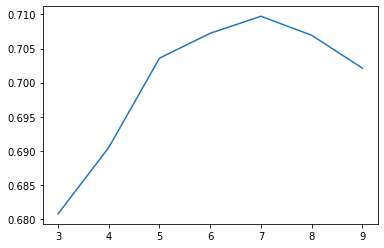

In [303]:
max_depth = []
depth_range = range(3, 10, 1)

for depth in depth_range:
    clf1 = DecisionTreeClassifier(max_depth = depth, min_samples_leaf = 1, criterion = 'entropy')
    clf1.fit(X_train[column_names], y_train)
    predict1 = clf1.predict_proba(X_test[column_names])[:,1]
    max_depth.append(roc_auc_score(y_test, predict1))

plt.plot(depth_range, max_depth)

#### 3. Варьируем минимальное количество выборок в листе

Лучший результат для 30, но изменения минимальные

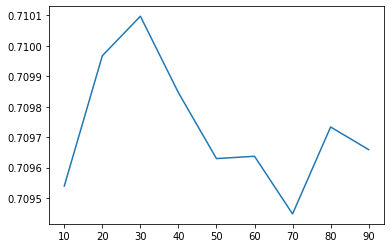

In [311]:
min_leaf = []
leaf_range = range(10, 100, 10)

for leaf in leaf_range:
    clf1 = DecisionTreeClassifier(max_depth = 7, min_samples_leaf = leaf, criterion = 'entropy')
    clf1.fit(X_train[column_names], y_train)
    predict1 = clf1.predict_proba(X_test[column_names])[:,1]
    min_leaf.append(roc_auc_score(y_test, predict1))

plt.plot(leaf_range, min_leaf)

### GridSearch

In [288]:
classifier = DecisionTreeClassifier()
parameters = {
    'criterion': ['entropy', 'gini'],
    'min_samples_leaf': range(10, 100, 20),
    'max_depth': range(1, 10)
}

grid_cv = GridSearchCV(classifier, parameters, scoring = 'roc_auc', cv = 5)

In [289]:
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['entropy', 'gini'],
                   

In [291]:
grid_cv.best_score_

0.7082329165518049

In [292]:
grid_cv.best_params_

{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 90}

### RandSearch
Глубина дерева +1 и другой критерий, в отличие от предыдущего

In [294]:
classifier = DecisionTreeClassifier()
parameters = {
    'criterion': ['entropy', 'gini'],
    'min_samples_leaf': range(10, 100, 20),
    'max_depth': range(1, 10)
}

grid_cv = RandomizedSearchCV(classifier, parameters, scoring = 'roc_auc', cv = 5)

In [296]:
grid_cv.best_score_

0.7067681130673635

In [297]:
grid_cv.best_params_

{'min_samples_leaf': 90, 'max_depth': 7, 'criterion': 'gini'}

#### Результат с kaggle  для GridSearch 0.69554

In [331]:
clf1 = DecisionTreeClassifier(max_depth = 6, min_samples_leaf = 90, criterion = 'entropy')
clf1.fit(train[column_names], y)
sample_submission["TARGET"] = clf1.predict_proba(test[column_names])[:,1]
sample_submission.to_csv("submission.csv", index = None)

## RandomForest

#### 1. Количество деревьев


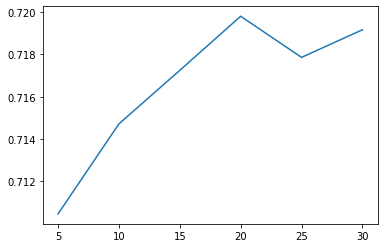

In [318]:
import warnings
warnings.filterwarnings('ignore')

n_estimators = []
n_range = [5, 10, 15, 20, 25, 30]

for n in n_range:
    clf1 = RandomForestClassifier(n_estimators = n, max_depth = 5, min_samples_leaf = 10)
    clf1.fit(X_train[column_names], y_train)
    predict1 = clf1.predict_proba(X_test[column_names])[:,1]
    n_estimators.append(roc_auc_score(y_test, predict1))

plt.plot(n_range, n_estimators)

#### 2. Глубина дерева

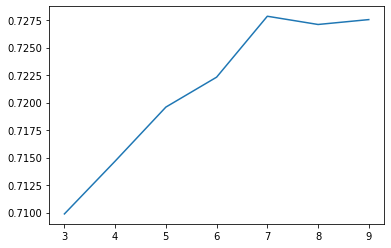

In [319]:
max_depth = []
depth_range = range(3, 10, 1)

for depth in depth_range:
    clf1 = RandomForestClassifier(n_estimators = 20, max_depth = depth, min_samples_leaf = 10)
    clf1.fit(X_train[column_names], y_train)
    predict1 = clf1.predict_proba(X_test[column_names])[:,1]
    max_depth.append(roc_auc_score(y_test, predict1))

plt.plot(depth_range, max_depth)

#### 3. Минимальное количество выборок в листе

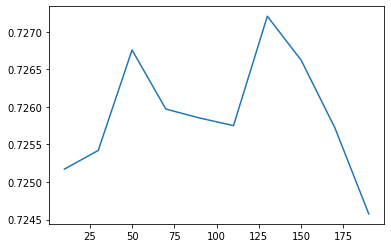

In [321]:
min_leaf = []
leaf_range = range(10, 200, 20)

for leaf in leaf_range:
    clf1 = RandomForestClassifier(n_estimators = 20, max_depth = 7, min_samples_leaf = leaf)
    clf1.fit(X_train[column_names], y_train)
    predict1 = clf1.predict_proba(X_test[column_names])[:,1]
    min_leaf.append(roc_auc_score(y_test, predict1))

plt.plot(leaf_range, min_leaf)

### GridSearch

In [322]:
classifier = RandomForestClassifier()
parameters = {
    'n_estimators': range(5, 30, 5),
    'min_samples_leaf': (10, 150, 20),
    'max_depth': range(3, 10)
}

grid_cv = GridSearchCV(classifier, parameters, scoring = 'roc_auc', cv = 5)

In [323]:
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [324]:
grid_cv.best_score_

0.7245012524981573

In [325]:
grid_cv.best_params_

{'max_depth': 9, 'min_samples_leaf': 150, 'n_estimators': 20}

### RandSearch

In [327]:
classifier = RandomForestClassifier()
parameters = {
    'n_estimators': range(5, 30, 5),
    'min_samples_leaf': (10, 150, 20),
    'max_depth': range(3, 10)
}

grid_cv = RandomizedSearchCV(classifier, parameters, scoring = 'roc_auc', cv = 5)

In [328]:
grid_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [329]:
grid_cv.best_score_

0.7234708319198678

In [330]:
grid_cv.best_params_

{'n_estimators': 20, 'min_samples_leaf': 150, 'max_depth': 9}

#### Результат с kaggle для RandSearch 0.70432

In [332]:
clf1 = RandomForestClassifier(max_depth = 9, min_samples_leaf = 150, n_estimators = 20)
clf1.fit(train[column_names], y)
sample_submission["TARGET"] = clf1.predict_proba(test[column_names])[:,1]
sample_submission.to_csv("submission.csv", index = None)

### Оценка важности признаков

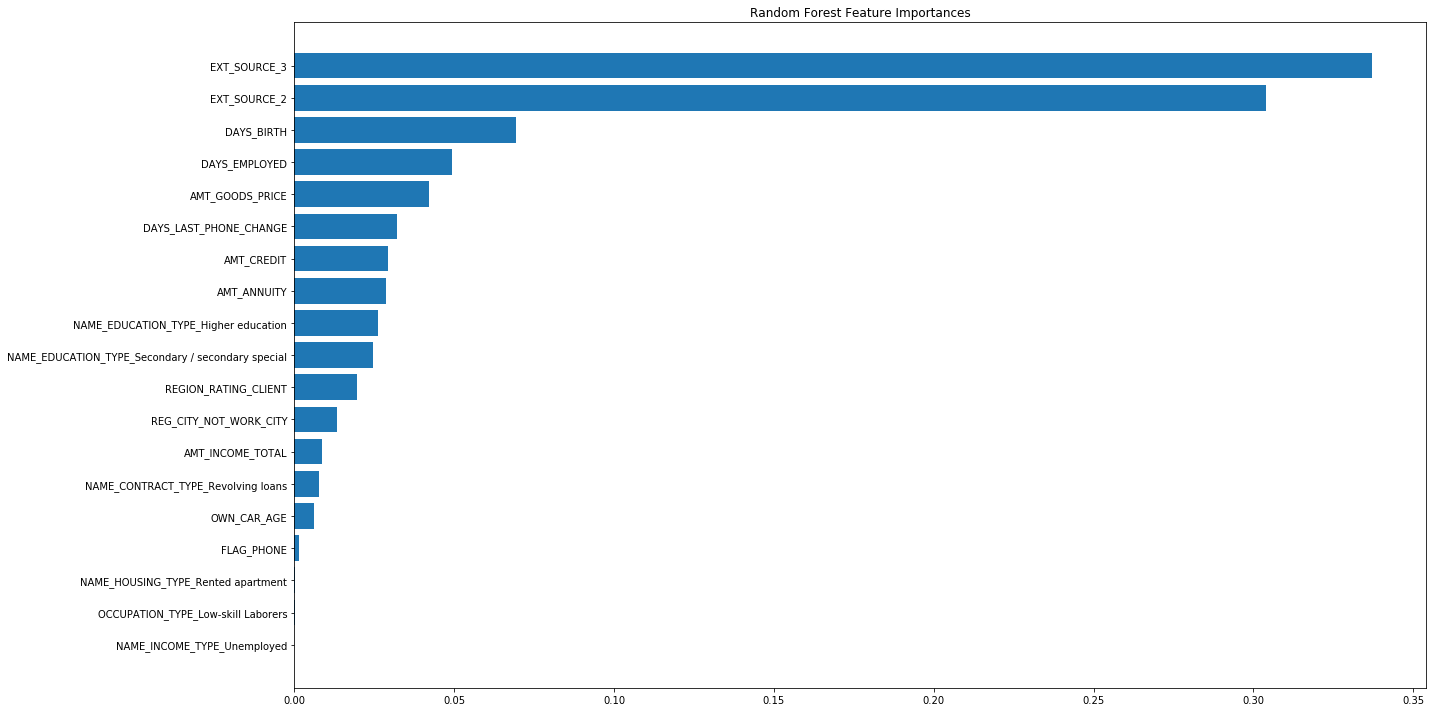

In [346]:
features = np.r_[train[column_names].columns]
clf1 = RandomForestClassifier(max_depth = 9, min_samples_leaf = 150, n_estimators = 20)
clf1.fit(train[column_names], y)

importance_id = clf1.feature_importances_.argsort()

y_ticks = np.arange(0, len(features))
fig, ax = plt.subplots(figsize=(20,10))
ax.barh(y_ticks, clf1.feature_importances_[importance_id])
ax.set_yticklabels(features[importance_id])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances")
fig.tight_layout()
plt.show()


Для 5 самых важных признаков скор почти не изменился в сравнении с полным набором (упал на 0,001)

In [347]:
column_names = ['EXT_SOURCE_3', 'EXT_SOURCE_2', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'AMT_GOODS_PRICE']

clf1 = RandomForestClassifier(max_depth = 9, min_samples_leaf = 150, n_estimators = 20)
clf1.fit(X_train[column_names], y_train)
predict1 = clf1.predict_proba(X_test[column_names])[:,1]
roc_auc_score(y_test, predict1)

0.7224836408704336

Для 4-х снизился на примерно на 0,004, что говорит о невысокой важность для модели и этого признака, тем не менее скор падает сильнее, чем когда мы убираем все признаки, кроме 5-ти

In [349]:
column_names = ['EXT_SOURCE_3', 'EXT_SOURCE_2', 'DAYS_BIRTH', 'DAYS_EMPLOYED']

clf1 = RandomForestClassifier(max_depth = 9, min_samples_leaf = 150, n_estimators = 20)
clf1.fit(X_train[column_names], y_train)
predict1 = clf1.predict_proba(X_test[column_names])[:,1]
roc_auc_score(y_test, predict1)

0.7181006899963656